In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
from matplotlib import rc
import scipy.integrate as integrate
from scipy.special import factorial
from tqdm import tqdm

In [2]:
# Matplotlib customize
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.borderpad'] = 0.6
plt.rcParams['legend.framealpha'] = 0.7

In [76]:
class BayesianCalculator:
    
    # Channels
    def __init__(self,channels,alpha = 0.05):
        
        self.n = channels[:,0]
        self.b = channels[:,1]
        self.s = channels[:,2]
        
        # NChannels
        self.N = channels.shape[0]
        
        self.alpha = alpha
    
    # POI ( Parameter of interest )
    def SetPOI(self,min_,max_,N : int):
        if not isinstance(N,int):
            raise ValueError(f"El valor de N debe ser un entero: {type(N).__name__}")
        self.mu = np.linspace(min_,max_,N)
    
    def GetPOI(self):
        return self.mu
    
    # Bayesian stuff
    def Prior(self,mu):
        if np.isscalar(mu):
            return 1. if mu > 0. else 0.
        else:
            return 1. if np.all(mu > 0) else 0.

        
    # Likelihood function
    def Likelihood(self,n,b,s,mu):
        lambda_ = mu*s+b
        
        try:
            L = np.exp( -lambda_ )*lambda_**n / factorial(n)
        except OverflowError:
            L = 0.0
        
        return L
        
    # JointLikelihood
    def GetJointLikelihood(self,mu):
        
        Like = 1.0
        
        # Likelihood in each channel
        for c in range(self.N):
            Like *= self.Likelihood(self.n[c],self.b[c],self.s[c],mu)
        
        # Aplicar el prior una sola vez
        Like *= self.Prior(mu)
            
        return Like
    
    # Normalization
    def GetNormalization(self):
        self.Normalization = integrate.quad( self.GetJointLikelihood, 0., np.inf )[0]
        return self.Normalization 
    
    
    # Posterior
    def GetPosterior(self,mu):
        return self.GetJointLikelihood(mu)/self.GetNormalization()
    
    
    def PlotPosterior(self):
        
        Posterior = np.array([ self.GetPosterior(mu_val) for mu_val in self.mu ])
    
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.plot(self.mu,Posterior,marker='o',color='k',label='Posterior Distribution')
        
        # Obtaining upper limit
        self.mup = self.GetUpperLimit()
        
        # Label X
        ax.set_xlabel(r'$\mu$')
        ax.xaxis.set_label_coords(0.95,-0.1)
        ax.set_xlim(self.mu[0],self.mu[-1])

        # Label Y
        ax.set_ylabel(r'$p(\mu;x)$')
        ax.yaxis.set_label_coords(-0.1,0.90)
        ax.set_ylim(np.min(Posterior),np.max(Posterior))
        
        # Ajustar los márgenes automáticamente
        plt.tight_layout()

        #Legend
        ax.legend(loc='upper right',bbox_to_anchor=(1,1),ncol=1,title='')
       
        #
        plt.savefig('BayesianUpperLimit.pdf')
    
    
    # P-value scan
    def GetPValueScan(self):
        
        self.pvalue = np.zeros( len(self.mu)  )
        
        for i in range(len(self.pvalue)):
            CL = integrate.quad( self.GetPosterior, 0., self.mu[i] )[0]
            #print(CL)
            self.pvalue[i] = 1. - CL
            
        return self.pvalue
    
    def PlotPValueScan(self):
        
        self.pvalue = self.GetPValueScan()
        
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.plot(self.mu,self.pvalue,marker='o',color='k',label='P-value scan')
        
        Upper = self.GetUpperLimit()
        print(Upper)
        
        ax.axhline( y = self.alpha, color='r', ls = '--', label=r'Critial Value: $\alpha= %.2f$'%(self.alpha) )
    
    
        # Label X
        ax.set_xlabel(r'$\mu$')
        ax.xaxis.set_label_coords(0.95,-0.1)
        ax.set_xlim(self.mu[0],self.mu[-1])

        # Label Y
        ax.set_ylabel(r'$P-value$')
        ax.yaxis.set_label_coords(-0.1,0.80)
        ax.set_ylim(np.min(self.pvalue),np.max(self.pvalue))
    
        
         # Ajustar los márgenes automáticamente
        plt.tight_layout()

        #Legend
        ax.legend(loc='upper right',bbox_to_anchor=(1,1),ncol=1,title='')
       
        #
        plt.savefig('BayesianPValueScan.pdf')
    
    
    # UpperLimit
    def GetUpperLimit(self):
        
        self.pvalue = self.GetPValueScan()
        
        i = np.where( self.pvalue <= self.alpha )
        
        if len(i[0]) == 0:
            print('--- pvalues is never less than alpha ---')
            return 0.
        else:
            i = i[0][0]
        # Saving the index where pvalue is less than the critical value
        
        x0 = self.mu[i-1]
        x1 = self.mu[i]
        fx0 = self.pvalue[i-1]
        fx1 = self.pvalue[i]

        # Calculamos la pendiente
        m = (fx1-fx0)/(x1-x0)
        
        if m == 0.:
            print('--- Problem with the scan ---')
            return 0.
        
        #1D polynomial interpolation
        self.mup = (self.alpha - fx0)/m + x0
        
        return self.mup
        
    
  # Imprimir canales
    def PrintChannels(self):
        for i in range(self.N):
            print(f"{i}: n={self.n[i]}, b={self.b[i]}, s={self.s[i]}")

In [77]:
# Prueba
channels = np.array([[0.,0.,1.]],dtype=float)

In [83]:
b1 = BayesianCalculator(channels)
b1.SetPOI(1.,7.,15)

In [84]:
b1.PrintChannels()

0: n=0.0, b=0.0, s=1.0


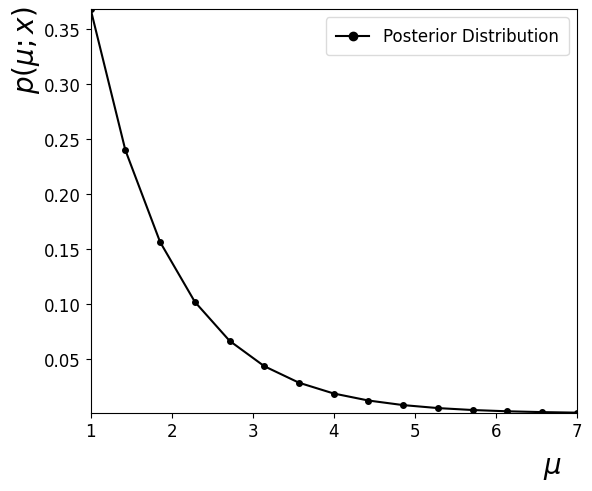

In [85]:
b1.PlotPosterior()

In [86]:
b1.GetUpperLimit()

3.015903911845227

3.015903911845227


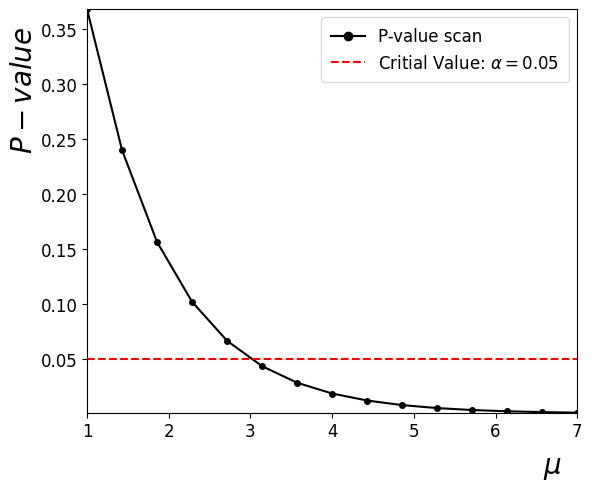

In [87]:
b1.PlotPValueScan()